# Analyzing the sampling rate from model-fitting logs

## Setup

In [1]:
import os
from datetime import timedelta
from io import StringIO
from pathlib import Path
from typing import Callable

import janitor  # noqa: F401
import pandas as pd
import plotnine as gg

In [2]:
from speclet.io import data_dir
from speclet.plot.plotnine_helpers import set_gg_theme

In [3]:
_ = gg.theme_set(gg.theme_minimal())

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Reading log files

In [5]:
LOG_DATA_DIR = data_dir() / "misc" / "blas-warning-advi-init-logs"
log_files = [f for f in LOG_DATA_DIR.iterdir() if f.suffix == ".log"]
log_files.sort()

In [6]:
def _extract_logging(fpath: Path) -> str:
    log_txt = ""
    read_line = False
    kill_terms = ["slurmstepd", "Killed", "Sampling 1 chain"]
    with open(fpath, "r") as file:
        for line in file:
            any_kill_terms = any([kt in line for kt in kill_terms])
            if any_kill_terms:
                break
            if read_line:
                log_txt += line.strip() + "\n"
            if "NUTS: " in line:
                read_line = True
    return log_txt


log_outputs = {f: _extract_logging(f) for f in log_files}

In [7]:
def _remove_prefix(col: pd.Series, prefix: str) -> list[str]:
    return [x.strip().replace(prefix, "") for x in col]


def log_to_df(log_txt: str) -> pd.DataFrame:
    log_data = (
        pd.read_csv(
            StringIO(log_txt),
            sep=",",
            header=None,
            names=["time", "chain", "draw", "stage", "num_divergences"],
            parse_dates=["time"],
        )
        .assign(
            draw=lambda d: _remove_prefix(d["draw"], "draw="),
            stage=lambda d: _remove_prefix(d["stage"], " "),
            num_divergences=lambda d: _remove_prefix(
                d["num_divergences"], "divergences="
            ),
            duration=lambda d: d["time"] - d["time"].min(),
        )
        .drop(columns=["chain"])
        .astype({"draw": int, "num_divergences": int})
    )
    return log_data


log_data = pd.concat(
    [log_to_df(txt).assign(log_file=fname.name) for fname, txt in log_outputs.items()]
).reset_index(drop=True)
log_data.head()

,time,draw,stage,num_divergences,duration,log_file
0,2022-02-05 15:05:23.129091,0,tune,0,0 days 00:00:00,48226952_sample_pymc3_mcmc.log
1,2022-02-05 15:05:58.140461,5,tune,0,0 days 00:00:35.011370,48226952_sample_pymc3_mcmc.log
2,2022-02-05 15:12:07.678560,10,tune,0,0 days 00:06:44.549469,48226952_sample_pymc3_mcmc.log
3,2022-02-05 15:14:41.497422,15,tune,0,0 days 00:09:18.368331,48226952_sample_pymc3_mcmc.log
4,2022-02-05 15:17:45.953554,20,tune,0,0 days 00:12:22.824463,48226952_sample_pymc3_mcmc.log


In [8]:
log_data["stage"] = pd.Categorical(
    log_data["stage"], categories=["tune", "sampling"], ordered=True
)

In [9]:
# "jitter+adapt_diag"
# "BLAS_warning"
chain_groups = {
    "48226952_sample_pymc3_mcmc.log": "advi",
    "48226953_sample_pymc3_mcmc.log": "advi",
    "48226954_sample_pymc3_mcmc.log": "no warning",
    "48226955_sample_pymc3_mcmc.log": "no warning",
    "48226956_sample_pymc3_mcmc.log": "no warning",
    "48226957_sample_pymc3_mcmc.log": "no warning",
    "48226958_sample_pymc3_mcmc.log": "advi",
    "48226959_sample_pymc3_mcmc.log": "advi",
    "48364687_sample_pymc3_mcmc.log": "BLAS warning",
    "48364681_sample_pymc3_mcmc.log": "BLAS warning",
    "48364682_sample_pymc3_mcmc.log": "BLAS warning",
    "48364686_sample_pymc3_mcmc.log": "BLAS warning",
    "49622311_sample_pymc_mcmc.log": "PyMC v4",
    "49534706_sample_pymc_mcmc.log": "PyMC v4",
    "49534705_sample_pymc_mcmc.log": "PyMC v4",
    "49534704_sample_pymc_mcmc.log": "PyMC v4",
}

log_data["chain_group"] = [chain_groups[log_name] for log_name in log_data.log_file]

In [10]:
if True:
    log_data = log_data.filter_column_isin(
        "chain_group", ["advi"], complement=True
    ).reset_index(drop=True)
    log_data["chain_group"] = pd.Categorical(
        log_data["chain_group"],
        categories=["BLAS warning", "no warning", "PyMC v4"],
        ordered=True,
    )

In [11]:
_cols = ["chain_group", "log_file"]
chain_indices = (
    log_data[_cols]
    .sort_values(_cols)
    .drop_duplicates()
    .reset_index(drop=True)
    .reset_index(drop=False)
    .assign(
        chain=lambda d: [f"{cg} ({i+1})" for cg, i in zip(d["chain_group"], d["index"])]
    )
    .assign(
        chain=lambda d: pd.Categorical(d["chain"], categories=d["chain"], ordered=True)
    )
)

log_data = log_data.merge(chain_indices, on=["log_file", "chain_group"])

In [12]:
(
    log_data[["chain", "chain_group", "log_file"]]
    .drop_duplicates()
    .sort_values("chain")
    .reset_index(drop=True)
)

,chain,chain_group,log_file
0,BLAS warning (1),BLAS warning,48364681_sample_pymc3_mcmc.log
1,BLAS warning (2),BLAS warning,48364682_sample_pymc3_mcmc.log
2,BLAS warning (3),BLAS warning,48364686_sample_pymc3_mcmc.log
3,BLAS warning (4),BLAS warning,48364687_sample_pymc3_mcmc.log
4,no warning (5),no warning,48226954_sample_pymc3_mcmc.log
5,no warning (6),no warning,48226955_sample_pymc3_mcmc.log
6,no warning (7),no warning,48226956_sample_pymc3_mcmc.log
7,no warning (8),no warning,48226957_sample_pymc3_mcmc.log
8,PyMC v4 (9),PyMC v4,49534704_sample_pymc_mcmc.log
9,PyMC v4 (10),PyMC v4,49534705_sample_pymc_mcmc.log


In [13]:
# n_tune = log_data.query("stage == 'tune'")["draw"].max()
n_tune = 1000

In [14]:
def calc_durations(log_df: pd.DataFrame) -> pd.DataFrame:
    delta_time = log_df["time"].values[1:] - log_df["time"].values[:-1]
    delta_draw = log_df["draw"].values[1:] - log_df["draw"].values[:-1]
    draw_durations = (
        pd.DataFrame(
            {
                "delta_time": delta_time,
                "delta_draw": delta_draw,
                "draw": log_df["draw"][1:],
            }
        )
        .merge(log_df.drop(columns=["time", "duration"]), on="draw", how="left")
        .assign(time_per_draw=lambda d: d.delta_time / d.delta_draw)
    )
    return draw_durations


draw_durations = log_data.groupby("chain").apply(calc_durations).reset_index(drop=True)
draw_durations.head()

,delta_time,delta_draw,draw,stage,num_divergences,log_file,chain_group,index,chain,time_per_draw
0,0 days 00:00:54.190434,5,5,tune,0,48364681_sample_pymc3_mcmc.log,BLAS warning,0,BLAS warning (1),0 days 00:00:10.838086800
1,0 days 00:09:55.622981,5,10,tune,0,48364681_sample_pymc3_mcmc.log,BLAS warning,0,BLAS warning (1),0 days 00:01:59.124596200
2,0 days 00:09:51.188408,5,15,tune,0,48364681_sample_pymc3_mcmc.log,BLAS warning,0,BLAS warning (1),0 days 00:01:58.237681600
3,0 days 00:09:45.961896,5,20,tune,0,48364681_sample_pymc3_mcmc.log,BLAS warning,0,BLAS warning (1),0 days 00:01:57.192379200
4,0 days 00:09:34.321183,5,25,tune,0,48364681_sample_pymc3_mcmc.log,BLAS warning,0,BLAS warning (1),0 days 00:01:54.864236600


## Current status

In [15]:
_cols = [
    "chain",
    "chain_group",
    "duration",
    "draw",
    "stage",
    "mins_per_draw",
    "num_divergences",
    "log_file",
]

current_sampling_rates = (
    draw_durations.assign(
        mins_per_draw=lambda d: [x.seconds / 60 for x in d.time_per_draw]
    )
    .groupby("chain")
    .tail(1)[["chain", "mins_per_draw"]]
)

sec_to_hour = 60 * 60

(
    log_data.groupby("chain")
    .tail(1)
    .sort_values(["chain_group", "chain"])
    .reset_index(drop=True)
    .merge(current_sampling_rates, on="chain")[_cols]
    .assign(
        duration=lambda d: [x.days * 24 + x.seconds / sec_to_hour for x in d.duration]
    )
    .round({"mins_per_draw": 2, "duration": 1})
    .rename(
        columns={
            "duration": "hours",
            "num_divergences": "# divergences",
            "mins_per_draw": "min. per draw",
            "chain_group": "group",
            "log_file": "log",
        }
    )
)

,chain,group,hours,draw,stage,min. per draw,# divergences,log
0,BLAS warning (1),BLAS warning,39.5,1995,sampling,0.52,0,48364681_sample_pymc3_mcmc.log
1,BLAS warning (2),BLAS warning,44.9,1995,sampling,0.53,0,48364682_sample_pymc3_mcmc.log
2,BLAS warning (3),BLAS warning,119.8,1675,sampling,4.18,0,48364686_sample_pymc3_mcmc.log
3,BLAS warning (4),BLAS warning,37.0,1995,sampling,0.53,0,48364687_sample_pymc3_mcmc.log
4,no warning (5),no warning,40.0,1995,sampling,0.52,0,48226954_sample_pymc3_mcmc.log
5,no warning (6),no warning,41.4,1995,sampling,0.58,0,48226955_sample_pymc3_mcmc.log
6,no warning (7),no warning,30.2,1995,sampling,0.52,0,48226956_sample_pymc3_mcmc.log
7,no warning (8),no warning,39.8,1995,sampling,0.52,0,48226957_sample_pymc3_mcmc.log
8,PyMC v4 (9),PyMC v4,18.0,1995,sampling,0.30,0,49534704_sample_pymc_mcmc.log
9,PyMC v4 (10),PyMC v4,30.3,1995,sampling,0.32,0,49534705_sample_pymc_mcmc.log


## Visualizations

In [16]:
line_kwargs = {"size": 0.5, "alpha": 0.5}
point_kwargs = {"size": 0.1, "alpha": 0.2}
smooth_kwargs = {
    "size": 0.8,
    "alpha": 0.25,
    "method": "loess",
}
tune_line_kwargs = {"linetype": "--", "color": "gray"}

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


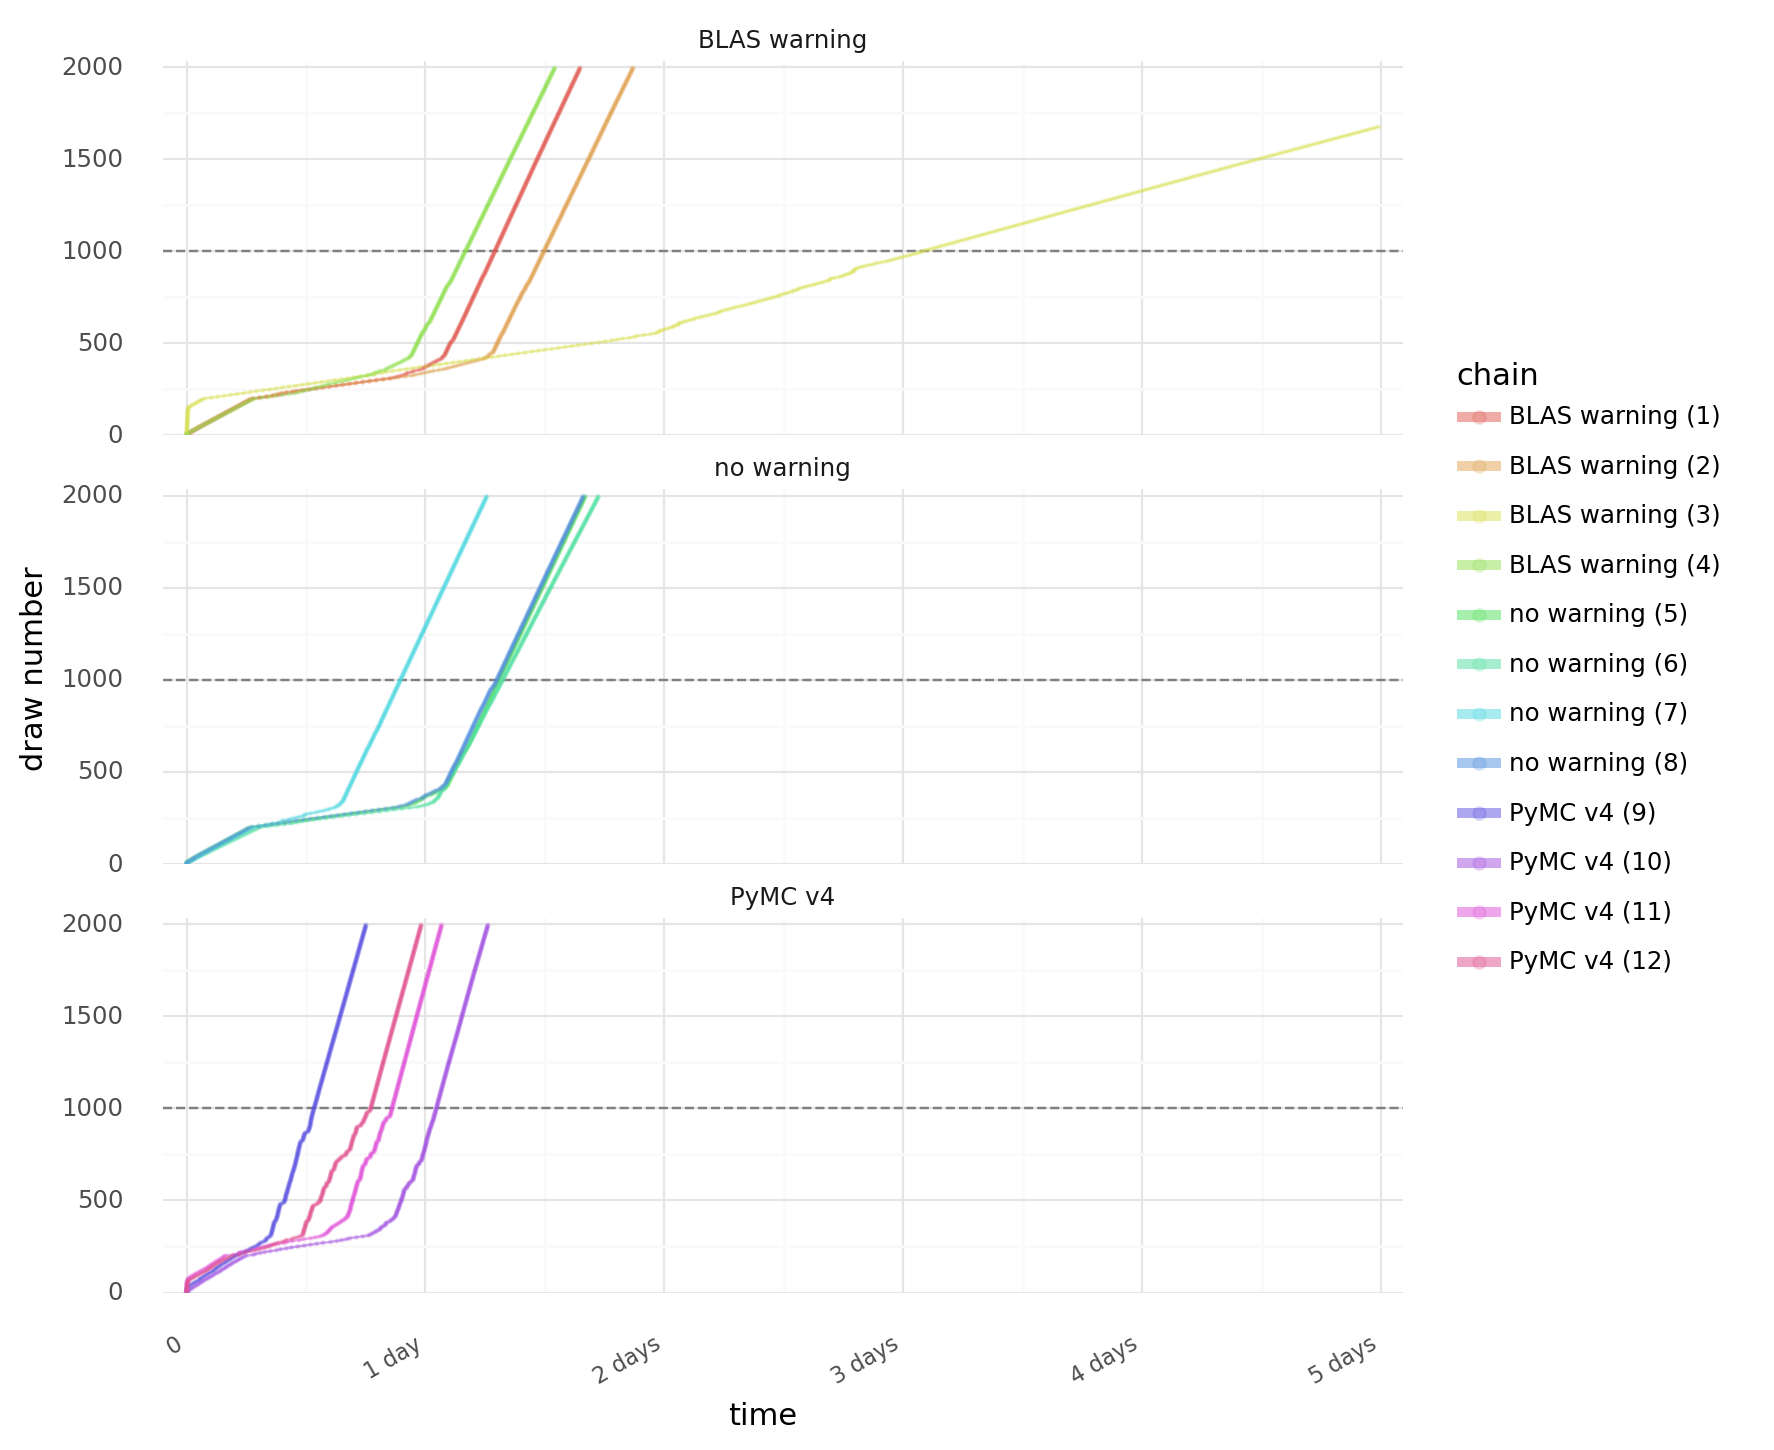

<ggplot: (333378654)>

In [17]:
(
    gg.ggplot(log_data, gg.aes(x="duration", y="draw"))
    + gg.facet_wrap("~chain_group", scales="fixed", ncol=1)
    + gg.geom_hline(yintercept=n_tune, **tune_line_kwargs)
    + gg.geom_line(
        gg.aes(group="chain", color="chain"),
        **line_kwargs,
    )
    + gg.geom_point(gg.aes(color="chain"), **point_kwargs)
    + gg.scale_x_timedelta(expand=(0.02, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_hue(s=0.7, guide=gg.guide_legend(override_aes={"size": 2}))
    + gg.theme(
        figure_size=(8, 8),
        legend_position="right",
        legend_background=gg.element_rect(alpha=0.5, size=0, color="white"),
        axis_text_x=gg.element_text(size=8, angle=30, hjust=1),
    )
    + gg.labs(x="time", y="draw number")
)

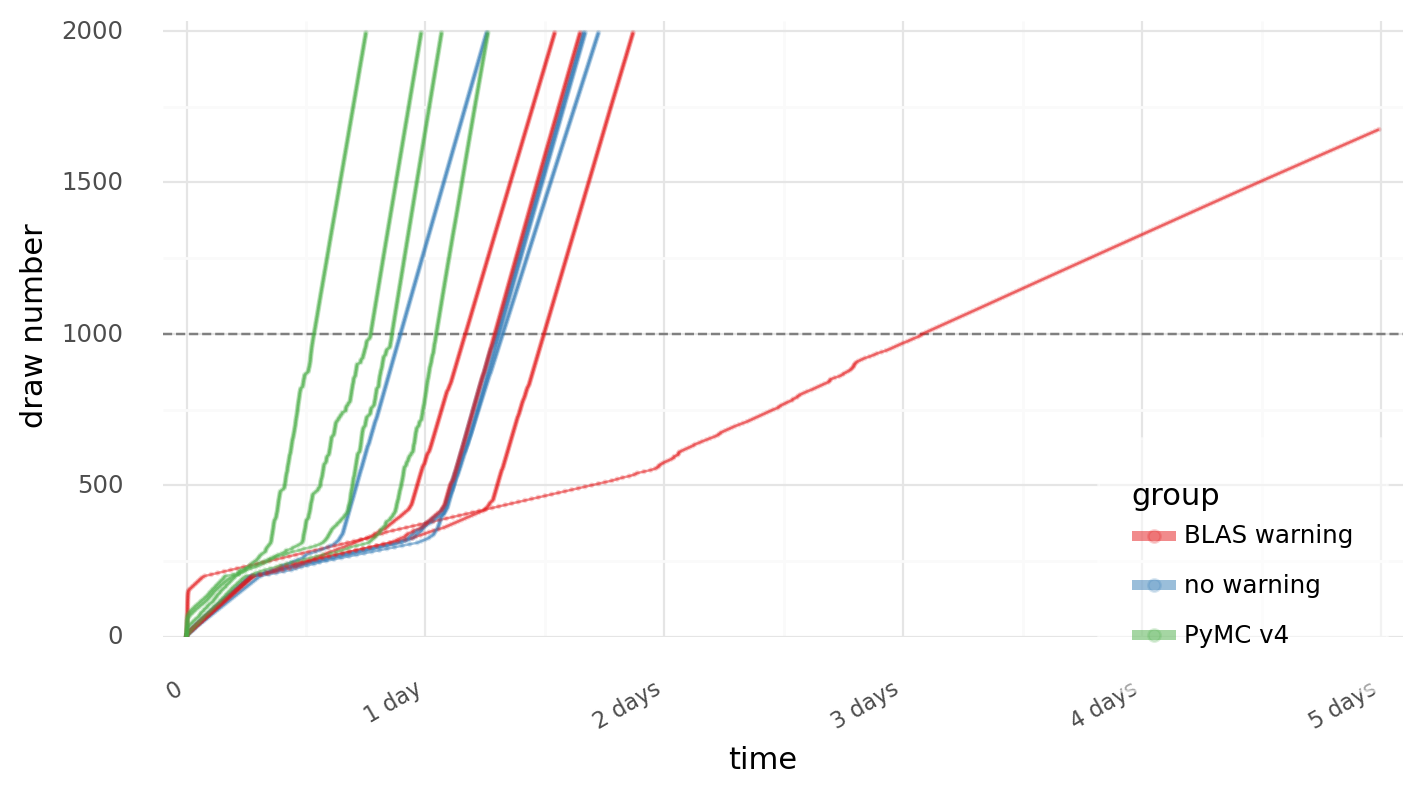

<ggplot: (333784564)>

In [18]:
(
    gg.ggplot(log_data, gg.aes(x="duration", y="draw"))
    + gg.geom_hline(yintercept=n_tune, **tune_line_kwargs)
    + gg.geom_line(
        gg.aes(group="chain", color="chain_group"),
        **line_kwargs,
    )
    + gg.geom_point(gg.aes(color="chain_group"), **point_kwargs)
    + gg.scale_x_timedelta(expand=(0.02, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(
        type="qual", palette="Set1", guide=gg.guide_legend(override_aes={"size": 2})
    )
    + gg.theme(
        figure_size=(8, 4),
        legend_position=(0.8, 0.2),
        legend_background=gg.element_rect(alpha=0.5, size=0, color="white"),
        axis_text_x=gg.element_text(size=8, angle=30, hjust=1),
    )
    + gg.labs(x="time", y="draw number", color="group")
)

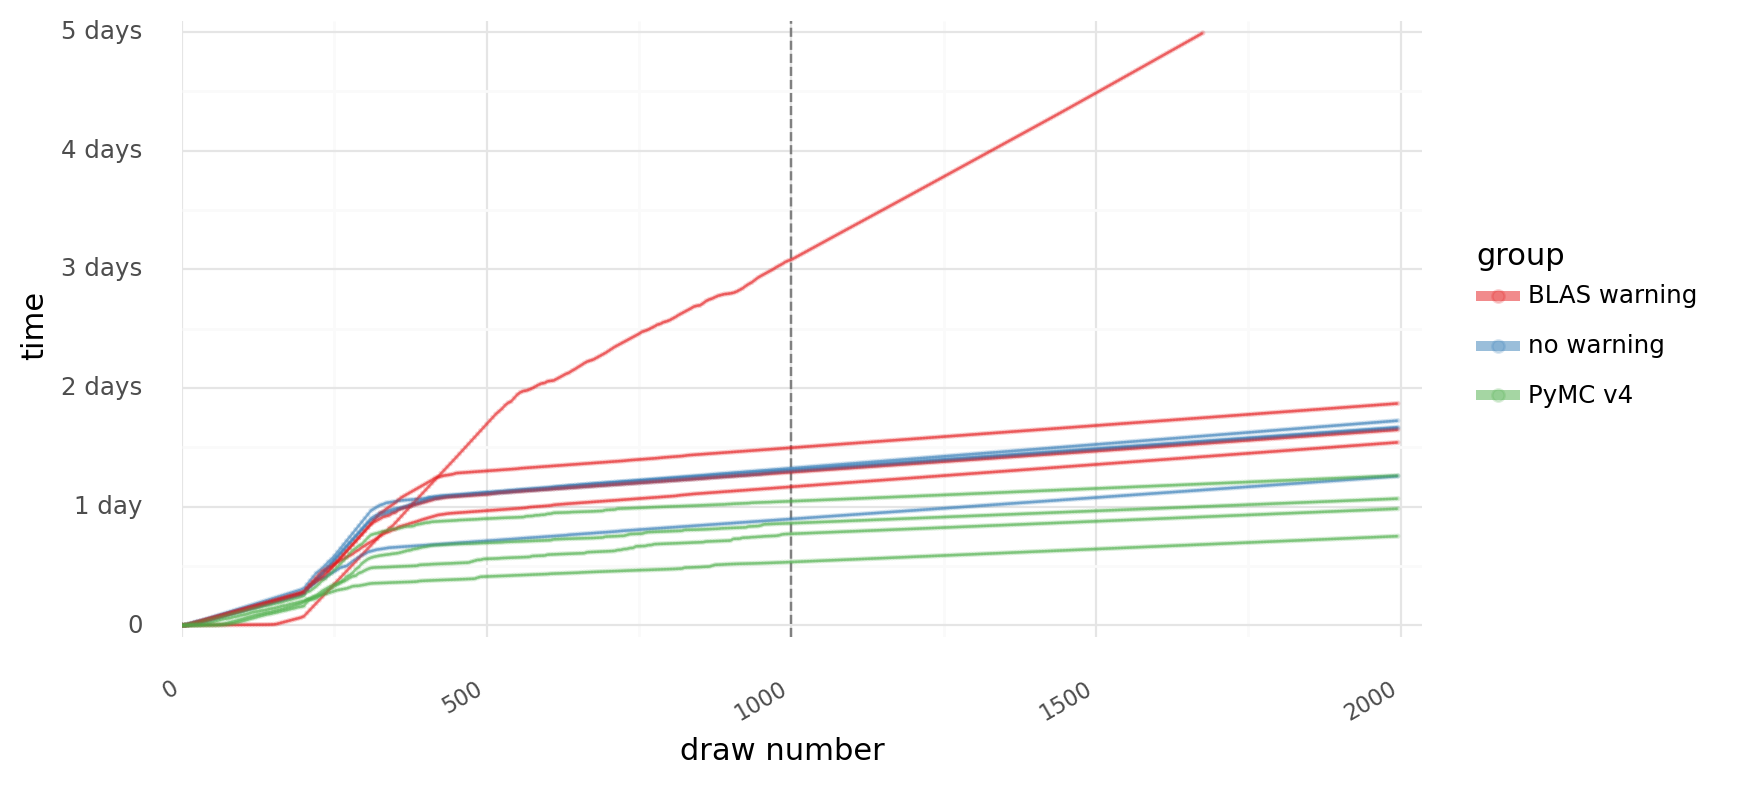

<ggplot: (333786143)>

In [19]:
(
    gg.ggplot(log_data, gg.aes(x="draw", y="duration"))
    + gg.geom_vline(xintercept=n_tune, **tune_line_kwargs)
    + gg.geom_line(
        gg.aes(group="chain", color="chain_group"),
        **line_kwargs,
    )
    + gg.geom_point(gg.aes(color="chain_group"), **point_kwargs)
    + gg.scale_x_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_y_timedelta(expand=(0.02, 0))
    + gg.scale_color_brewer(
        type="qual", palette="Set1", guide=gg.guide_legend(override_aes={"size": 2})
    )
    + gg.theme(
        figure_size=(8, 4),
        legend_position="right",
        legend_background=gg.element_rect(alpha=0.5, size=0, color="white"),
        axis_text_x=gg.element_text(size=8, angle=30, hjust=1),
    )
    + gg.labs(y="time", x="draw number", color="group")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/

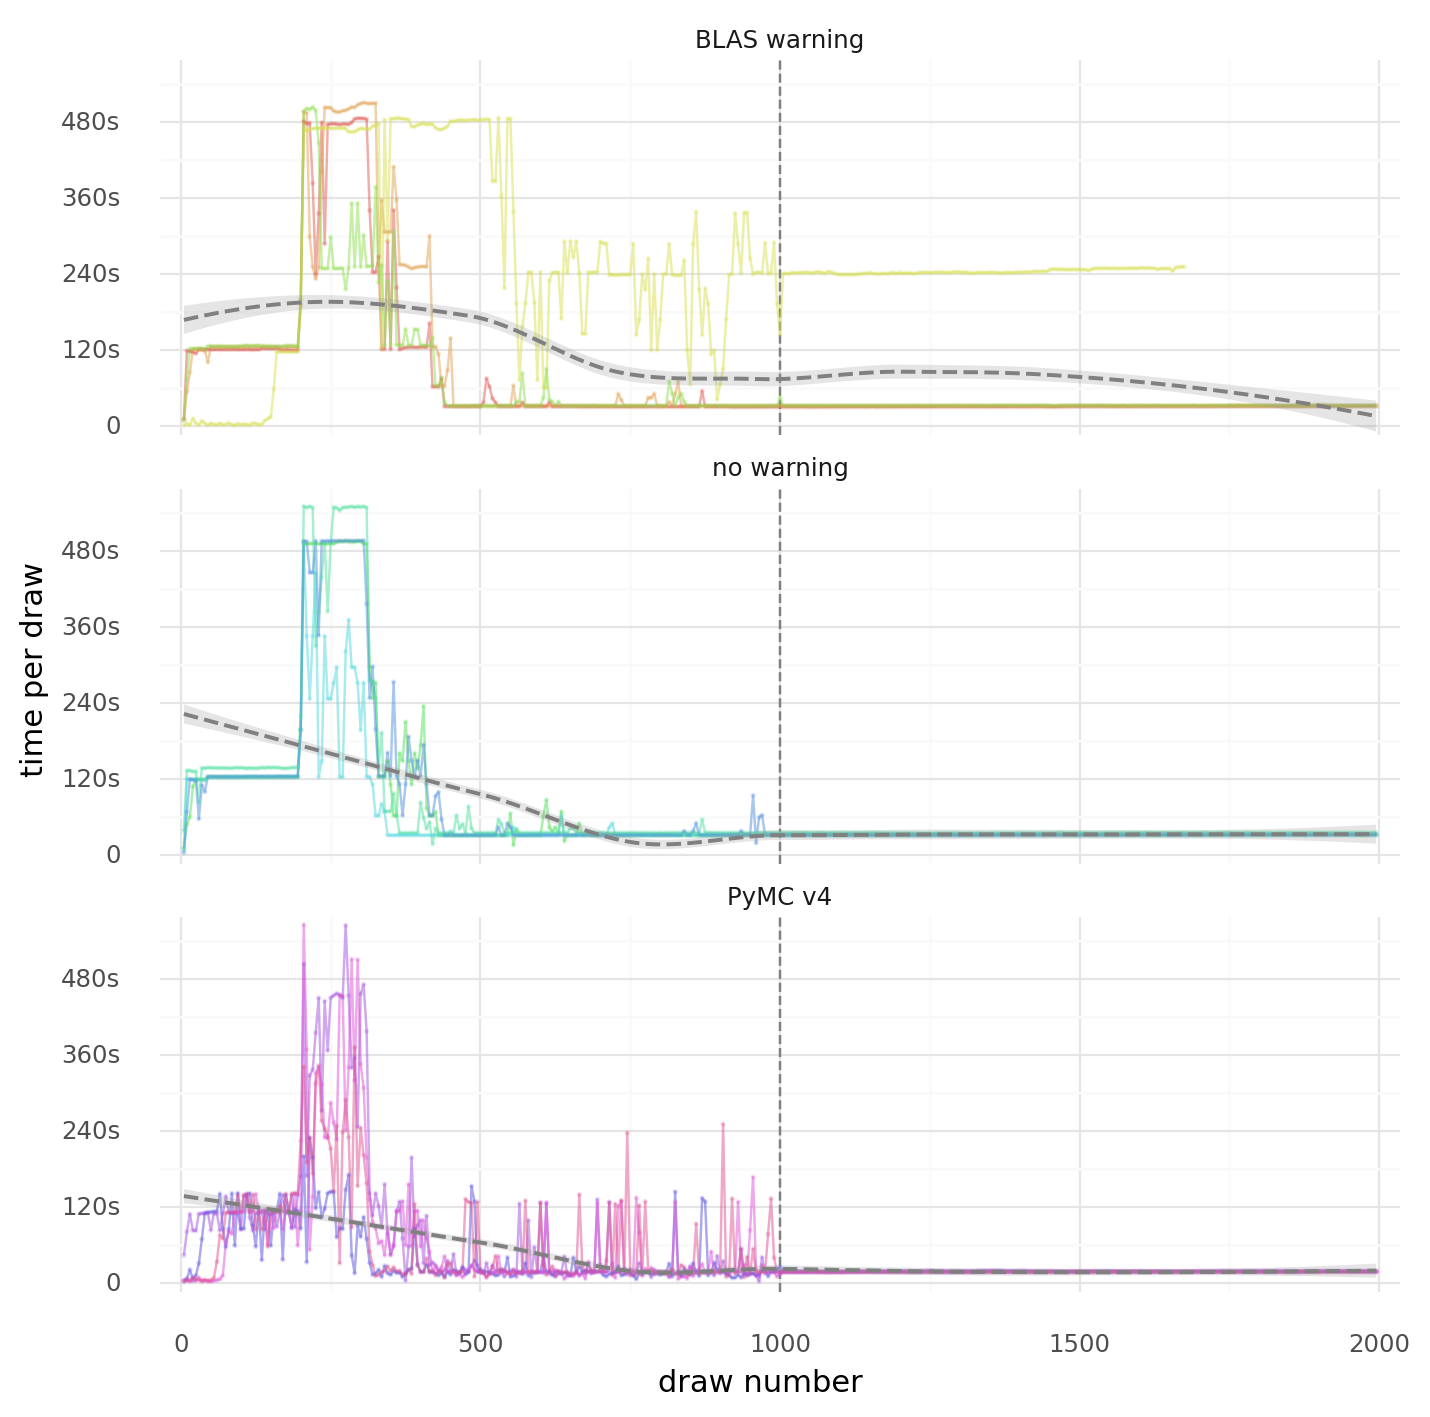

<ggplot: (333983657)>

In [20]:
(
    gg.ggplot(draw_durations, gg.aes(x="draw", y="time_per_draw"))
    + gg.facet_wrap("~chain_group", ncol=1)
    + gg.geom_vline(xintercept=n_tune, **tune_line_kwargs)
    + gg.geom_line(gg.aes(color="chain"), **line_kwargs)
    + gg.geom_point(gg.aes(color="chain"), **point_kwargs)
    + gg.geom_smooth(**smooth_kwargs, linetype="--", color="gray")
    + gg.scale_x_continuous(expand=(0.02, 0.02))
    + gg.scale_y_timedelta(expand=(0.01, 0, 0.02, 0))
    + gg.scale_color_hue(s=0.7, guide=gg.guide_legend(override_aes={"size": 2}))
    + gg.theme(figure_size=(8, 8), legend_position="none")
    + gg.labs(x="draw number", y="time per draw")
)

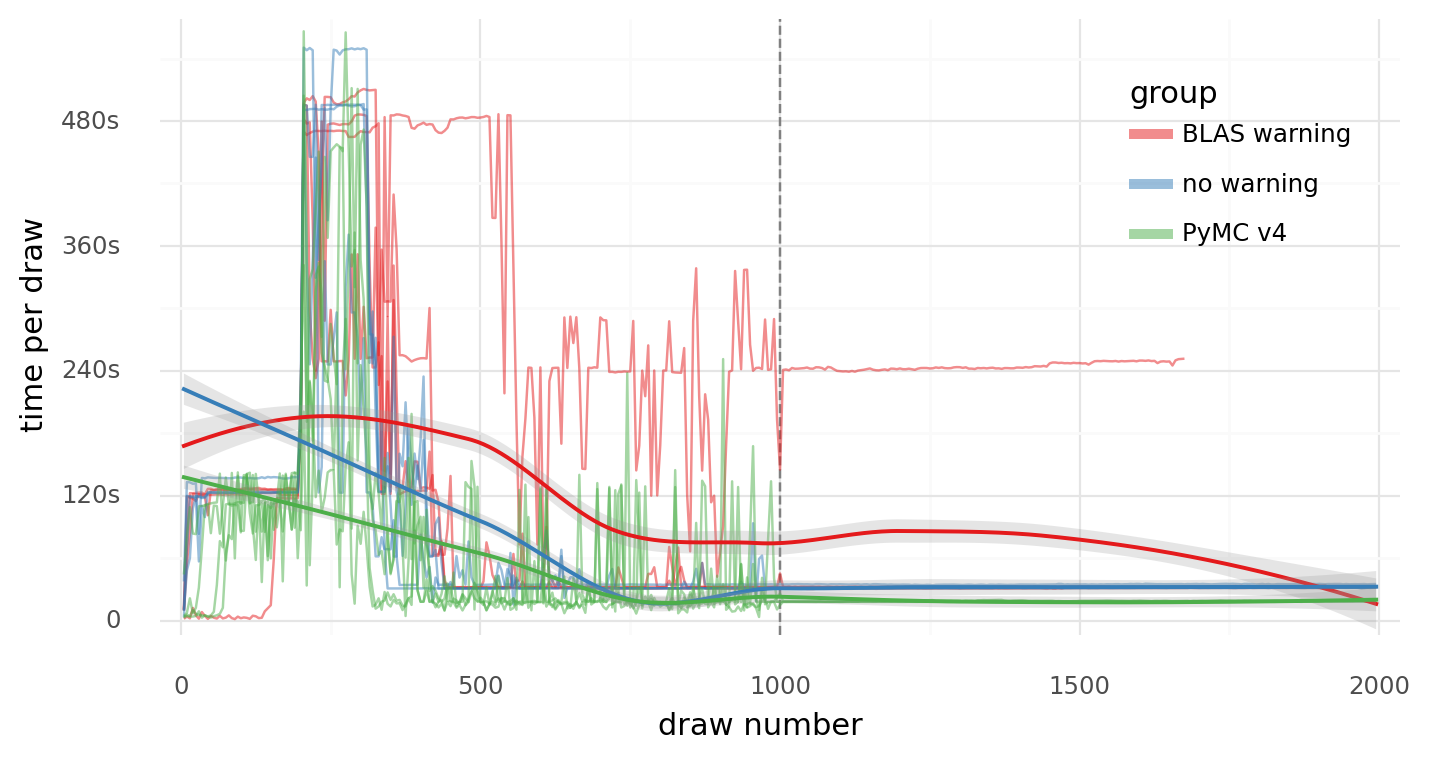

<ggplot: (333878812)>

In [21]:
(
    gg.ggplot(draw_durations, gg.aes(x="draw", y="time_per_draw"))
    + gg.geom_vline(xintercept=n_tune, **tune_line_kwargs)
    + gg.geom_line(gg.aes(group="chain", color="chain_group"), **line_kwargs)
    # + gg.geom_point(gg.aes(color="chain_group"), **point_kwargs)
    + gg.geom_smooth(
        gg.aes(color="chain_group"), **smooth_kwargs, linetype="-", show_legend=False
    )
    + gg.scale_x_continuous(expand=(0.02, 0.02))
    + gg.scale_y_timedelta(expand=(0.01, 0, 0.02, 0))
    + gg.scale_color_brewer(
        type="qual", palette="Set1", guide=gg.guide_legend(override_aes={"size": 2})
    )
    + gg.theme(figure_size=(8, 4), legend_position=(0.8, 0.7))
    + gg.labs(x="draw number", y="time per draw", color="group")
)

Same plot as above except with the outlier removed.

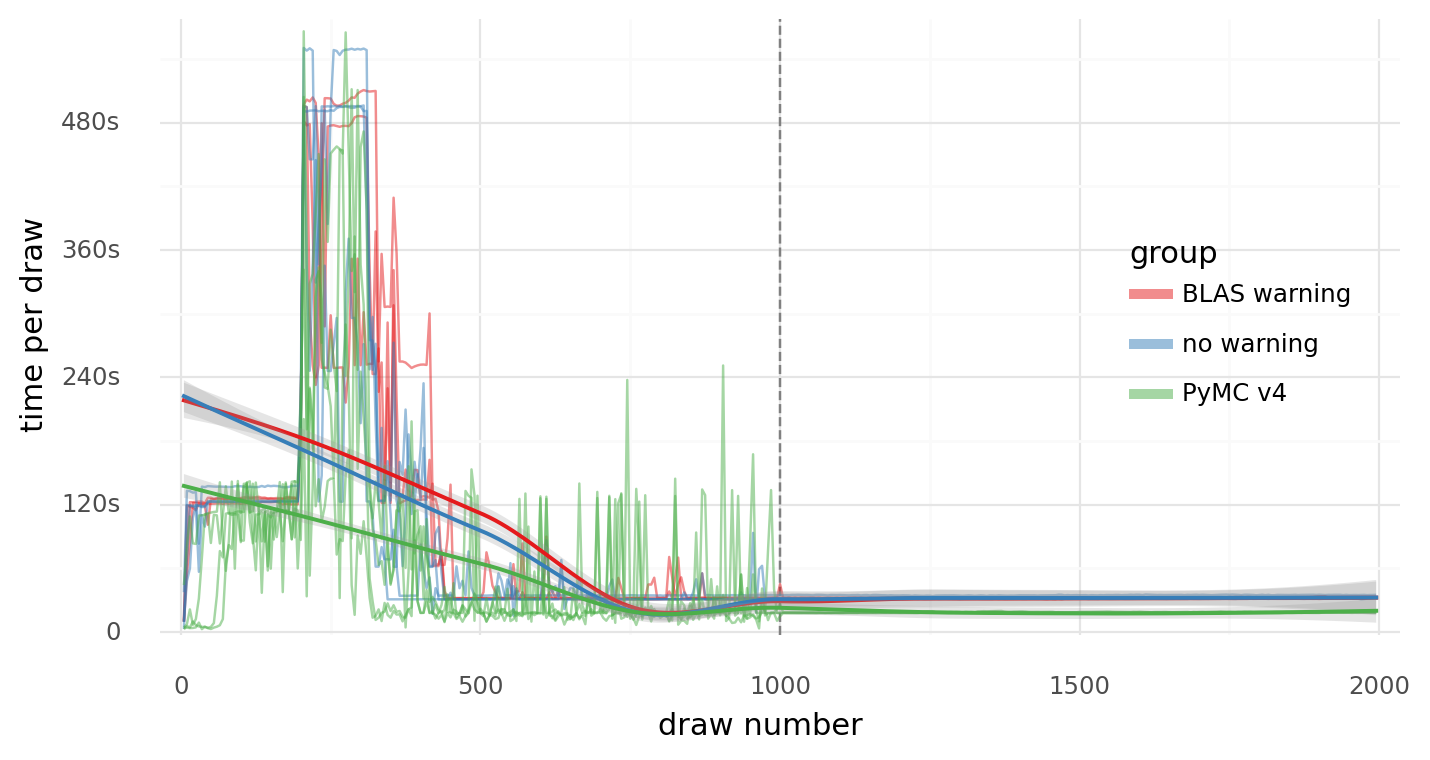

<ggplot: (333240441)>

In [22]:
(
    gg.ggplot(
        draw_durations.query("chain != 'BLAS warning (3)'"),
        gg.aes(x="draw", y="time_per_draw"),
    )
    + gg.geom_vline(xintercept=n_tune, **tune_line_kwargs)
    + gg.geom_line(gg.aes(group="chain", color="chain_group"), **line_kwargs)
    # + gg.geom_point(gg.aes(color="chain_group"), **point_kwargs)
    + gg.geom_smooth(
        gg.aes(color="chain_group"), **smooth_kwargs, linetype="-", show_legend=False
    )
    + gg.scale_x_continuous(expand=(0.02, 0.02))
    + gg.scale_y_timedelta(expand=(0.01, 0, 0.02, 0))
    + gg.scale_color_brewer(
        type="qual", palette="Set1", guide=gg.guide_legend(override_aes={"size": 2})
    )
    + gg.theme(figure_size=(8, 4), legend_position=(0.8, 0.5))
    + gg.labs(x="draw number", y="time per draw", color="group")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/positions/position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/positions/position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/positions/position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals


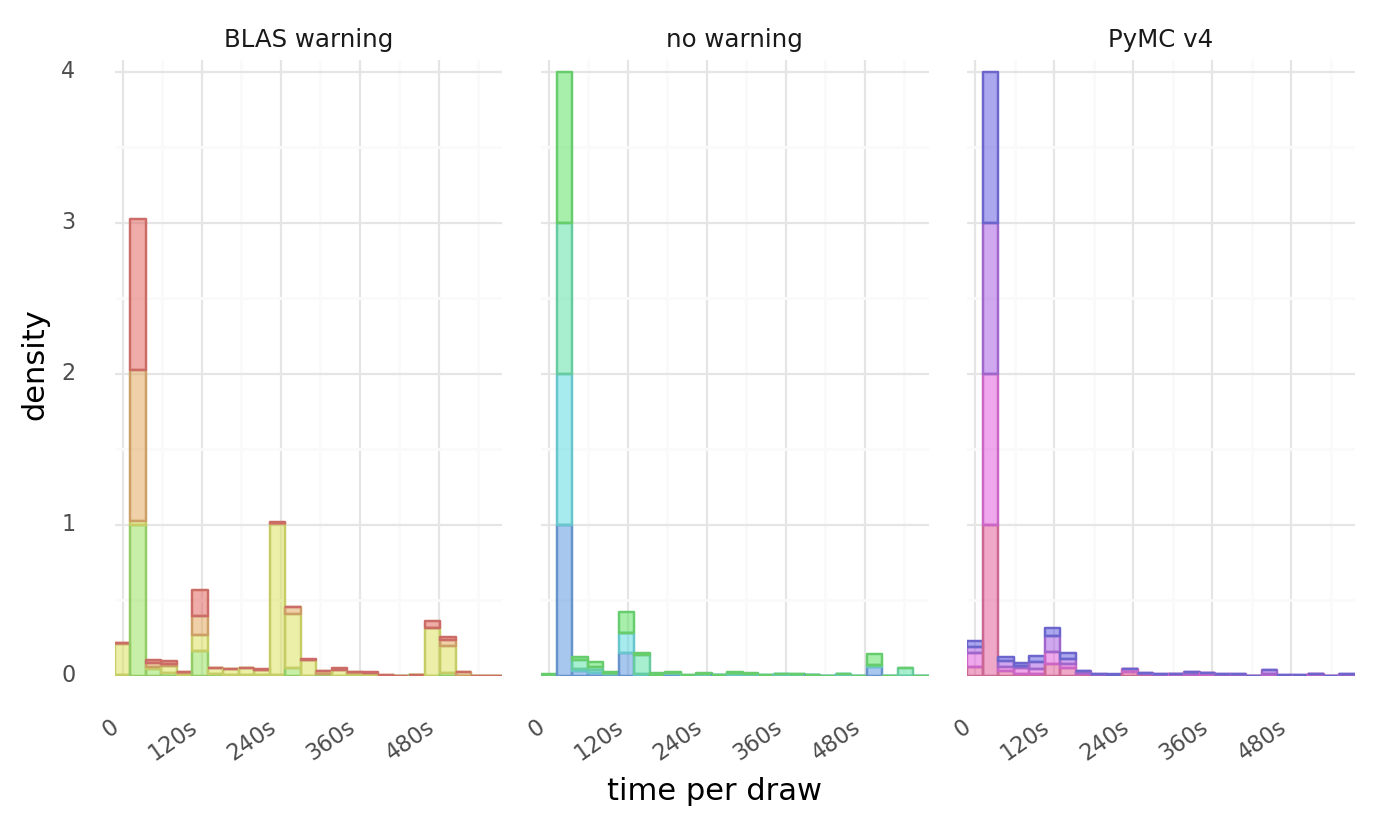

<ggplot: (334191984)>

In [23]:
(
    gg.ggplot(draw_durations, gg.aes(x="time_per_draw", color="chain", fill="chain"))
    + gg.facet_wrap(" ~ chain_group")
    + gg.geom_histogram(
        gg.aes(y=gg.after_stat("ncount")), bins=25, alpha=0.5, position="stack"
    )
    + gg.scale_x_timedelta(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_hue(s=0.5, guide=gg.guide_legend(override_aes={"size": 1.5}))
    + gg.scale_fill_hue(s=0.7)
    + gg.theme(
        figure_size=(8, 4),
        legend_position="none",
        legend_title=gg.element_blank(),
        axis_text=gg.element_text(size=8),
        axis_text_x=gg.element_text(angle=35, hjust=1),
        subplots_adjust={"wspace": 0.1},
    )
    + gg.labs(x="time per draw", y="density")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


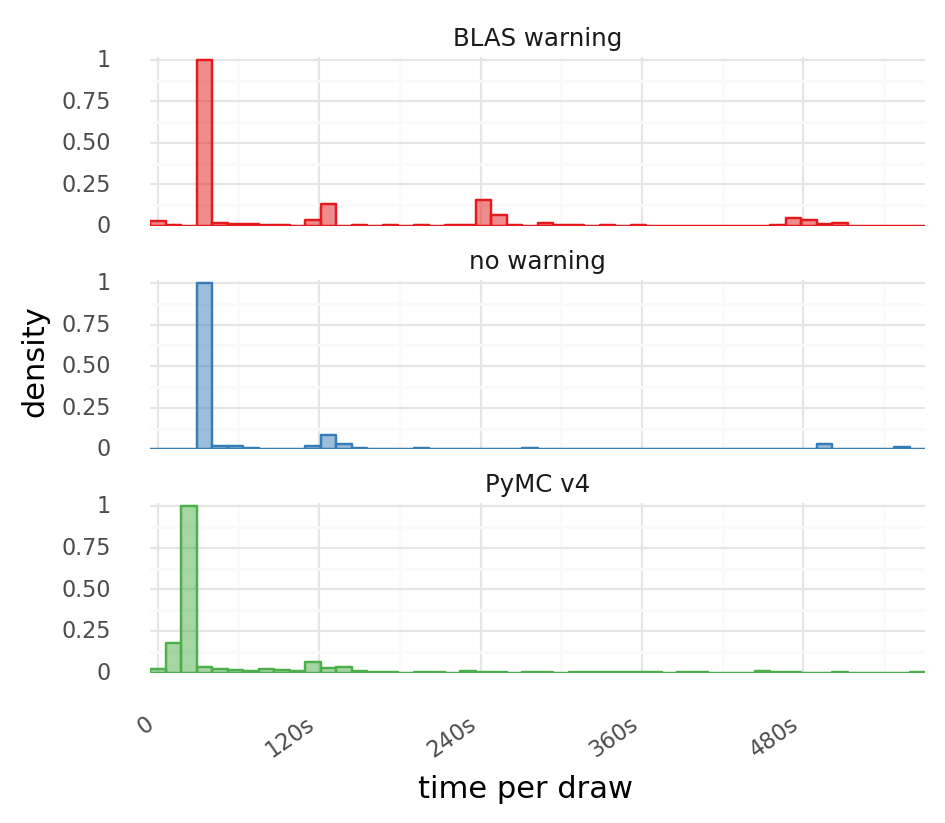

<ggplot: (334376292)>

In [24]:
(
    gg.ggplot(
        draw_durations,
        gg.aes(x="time_per_draw", color="chain_group", fill="chain_group"),
    )
    + gg.facet_wrap("~chain_group", ncol=1, scales="fixed")
    + gg.geom_histogram(
        gg.aes(y=gg.after_stat("ncount")), bins=50, alpha=0.5, position="identity"
    )
    + gg.scale_x_timedelta(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.theme(
        figure_size=(5, 4),
        legend_title=gg.element_blank(),
        legend_position="none",
        axis_text=gg.element_text(size=8),
        axis_text_x=gg.element_text(angle=35, hjust=1),
    )
    + gg.labs(x="time per draw", y="density")
)

## Summary table

In [25]:
def _rename_summary_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(columns=["chain"]).rename(
        columns={"chain_group": "chain group", "index": "chain"}
    )


def _set_summary_index(df: pd.DataFrame) -> pd.DataFrame:
    return df.set_index(["chain group", "chain", "stage"])

In [26]:
# Summarize total duration.
total_time_summary = (
    log_data.assign(
        duration=lambda d: [x.days * 24 + x.seconds / 60 / 60 for x in d.duration]
    )
    .pipe(_rename_summary_cols)
    .groupby(["chain", "chain group", "stage"])["duration"]
    .max()
    .reset_index(drop=False)
    .dropna()
    .pipe(_set_summary_index)
)

In [27]:
# Summarize draw durations.
draw_durations_summary = (
    draw_durations.assign(
        delta_time=lambda d: [x.days * 24 + x.seconds / 60 for x in d.delta_time]
    )
    .pipe(_rename_summary_cols)
    .groupby(["chain group", "chain", "stage"])["delta_time"]
    .describe()
    .drop(columns=["count"])
)

In [28]:
# Combine both summaries.
full_summary = total_time_summary.merge(
    draw_durations_summary, left_index=True, right_index=True
)
_col_idx = [("total (hr.)", "duration")] + [
    ("draw rate (min.)", x) for x in draw_durations_summary.columns
]
full_summary.columns = pd.MultiIndex.from_tuples(_col_idx)

In [32]:
# print(full_summary.style.format(precision=1).to_html())
full_summary.style.format(precision=1)

---

## Session info

In [33]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2022-03-04

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: add-nb-model

janitor : 0.22.0
plotnine: 0.8.0
pandas  : 1.4.1

